### 비트 코인 가격 예측  
https://www.blockchain.com/explorer/charts/market-price

- auto_arima를 사용하여 적합한 모델을 찾고, 이를 통해 금융 데이터 포트폴리오를 제작한다.

In [1]:
import pandas as pd
import json

# json 파일을 로드 한다.
with open('./datasets/bitcoin_2010_2024.json') as f: 
    json_data = json.load(f)

# 기존 json 파일에 존재하던 market-price 정보만을 가져와서 DataFrame 형태로 만든다. (pandas 라이브러리의 DataFrame)
bitcoin_df = pd.DataFrame(json_data['market-price'])
bitcoin_df

,x,y
0,1230940800000,0.00
1,1231286400000,0.00
2,1231632000000,0.00
3,1231977600000,0.00
4,1232323200000,0.00
...,...,...
1405,1716508800000,67942.23
1406,1716854400000,69374.17
1407,1717200000000,67484.93
1408,1717545600000,70553.24


In [2]:
from datetime import datetime
# 날짜에 해당하던 x Feature가 밀리초 단위로 되어있기 때문에 이를 1000으로 나눠주고 초 단위로 변경된 값을, 
#timestamp라는 변수에 담아준다.
# datetime 라이브러리를 사용해서 fromtimestamp함수에 변환된 초 단위를 timestamp 변수를 담아주고 이를 '년-월-일' 형태로 바꿔준다. - strftime(원하는 날짜형식으로 바꿔주는 함수)
def changeDate(milis):
    timestamp = milis / 1000
    converted_time = datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')
    return converted_time

In [3]:
# 실제 dataframe에 날짜에 해당하는 특성에 위에서 설정한 날짜 형식 함수를 apply 함수로 적용시킨다.
bitcoin_df.x = bitcoin_df.x.apply(changeDate)
bitcoin_df

,x,y
0,2009-01-03,0.00
1,2009-01-07,0.00
2,2009-01-11,0.00
3,2009-01-15,0.00
4,2009-01-19,0.00
...,...,...
1405,2024-05-24,67942.23
1406,2024-05-28,69374.17
1407,2024-06-01,67484.93
1408,2024-06-05,70553.24


In [4]:
# bitcoin_df의 'x' 열을 인덱스로 설정. 이 작업은 inplace=True 매개변수를 통해 데이터프레임을 직접 변경.

bitcoin_df.set_index('x', inplace=True)

bitcoin_df

,y
x,
2009-01-03,0.00
2009-01-07,0.00
2009-01-11,0.00
2009-01-15,0.00
2009-01-19,0.00
...,...
2024-05-24,67942.23
2024-05-28,69374.17
2024-06-01,67484.93


In [5]:
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1410 entries, 2009-01-03 to 2024-06-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       1410 non-null   float64
dtypes: float64(1)
memory usage: 22.0+ KB


In [6]:
# 설정한 인덱스를 다시 날짜형식으로 설정
# 그래야 차트 x 축에 연 단위로 나온다.
bitcoin_df.index = pd.to_datetime(bitcoin_df.index)
bitcoin_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1410 entries, 2009-01-03 to 2024-06-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       1410 non-null   float64
dtypes: float64(1)
memory usage: 22.0 KB


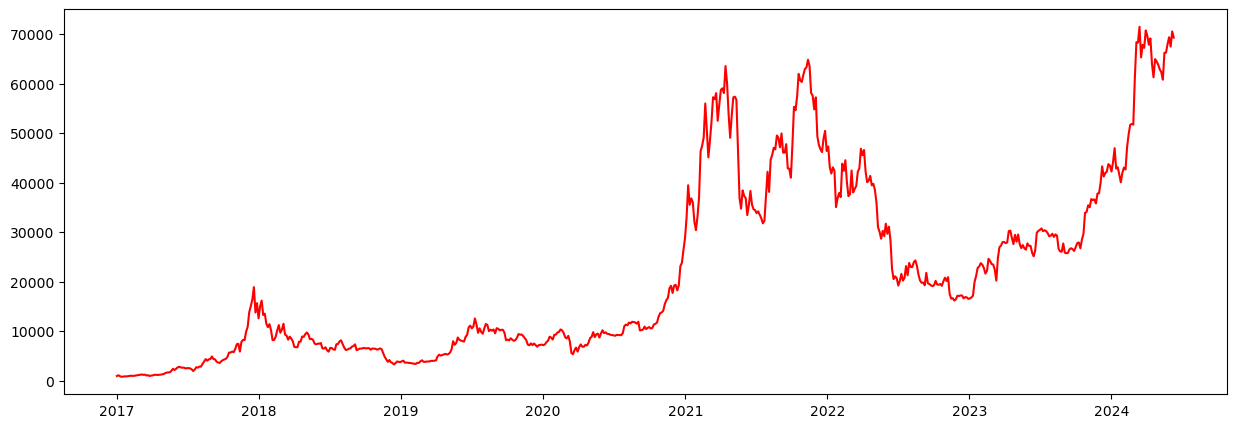

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.plot(bitcoin_df['2017-01-01':], c='red')
plt.show()

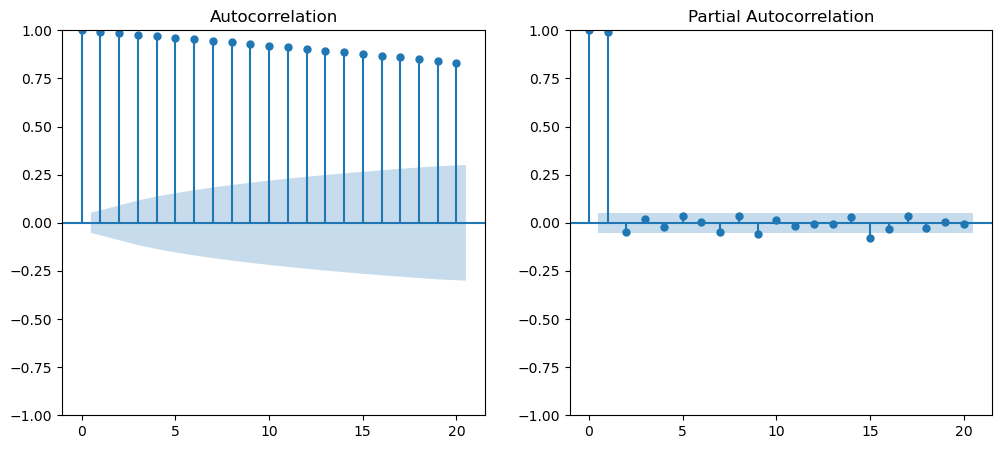

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# 자기상관함수(acf 사용---> 시계열의 형태를 확인 가능)
fig = plot_acf(bitcoin_df, lags=20, ax=ax[0])
# 부분자기상관함수(pacf 사용 --> 각각의 시차와의 상관관계를 나타낸다.)
fig = plot_pacf(bitcoin_df, lags=20, ax=ax[1])

In [9]:
bitcoin_df = bitcoin_df['2017-01-01':]
bitcoin_df

,y
x,
2017-01-01,964.84
2017-01-05,1109.16
2017-01-09,910.49
2017-01-13,805.52
2017-01-17,830.56
...,...
2024-05-24,67942.23
2024-05-28,69374.17
2024-06-01,67484.93


In [10]:
# pre_bitcoin_df = bitcoin_df[['y']].iloc[-252:]
# pre_bitcoin_df

In [11]:
y_train = bitcoin_df['y'][:int(0.8 * len(bitcoin_df))] # 80%
y_test = bitcoin_df['y'][int(-0.2 * len(bitcoin_df)):] # 20 %

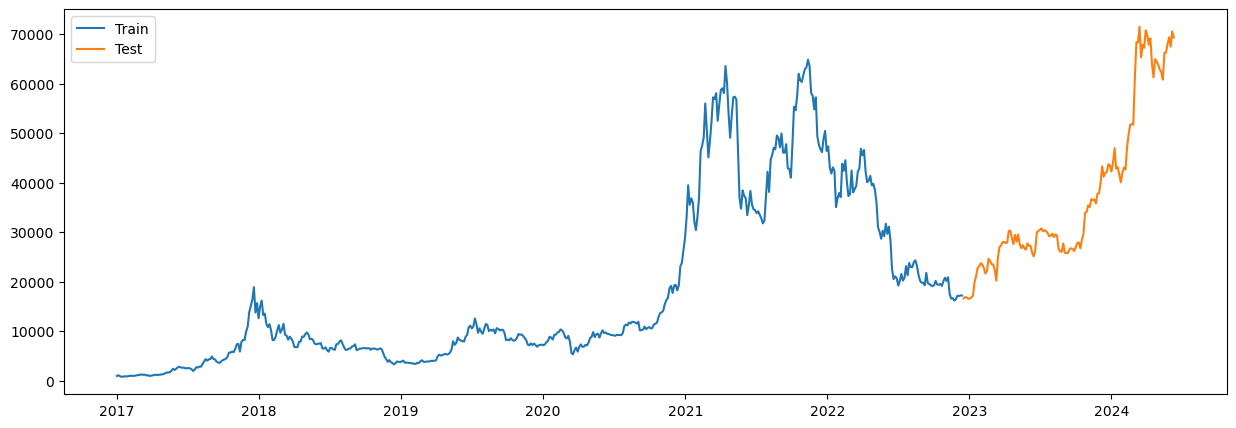

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.legend()
plt.show()

In [13]:
from pmdarima.arima import ndiffs
# KPSS(Kwaiatkowski-Phillips-Schmidt-Shin)
# 차분을 진행하는 것이 필요할 지 결정하기 위해 사용하는 한 가지 검정 방법
# 영가설(귀무가설)을 "데이터에 정상성이 나타난다."로 설정한 뒤
# 영가설이 거짓이라는 증거를 찾는 알고리즘이다.
kpass_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
pp_diffs = ndiffs(y_train, alpha=0.05, test='pp', max_d=6)

n_diffs = max(kpass_diffs, adf_diffs, pp_diffs)

print(f'd={n_diffs}')

d=1


In [14]:
import pmdarima as pm

model = pm.auto_arima(y=y_train, d=1, start_p=0, max_p=3, start_q=0,
                     max_q=3, m=1, seasonal=True, stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9728.517, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9726.582, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9726.546, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9726.657, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9728.545, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=9728.592, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9730.550, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=9724.663, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=9726.662, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=9726.709, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=9724.698, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=9728.605, Time=0.10 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.489 seconds


In [15]:
model.fit(y_train)

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [16]:
# portpolio 에 꼭 적자. 
# Prob(q) , 융-박스 검정 통계량 
# 영가설 : 잔차가 백색잡음 시계열을 따른다. 
# 0.05 이상 : 서로 독립이고 동일한 분포를 따른다. 

# Prob(H) , 이분산성 검정 통계량 
# 영가설 : 잔차가 이분산성을 띄지 않는다. 
# 0.05 이상 : 잔차의 분산이 일정하다.

# Prob(JB) , 자크-베라 검정 통계량  
# 영가설 : 잔차가 정규성을 따른다. 
# 0.05 이상 : 일정한 평균과 분산을 따른다. 

# Skew : 쏠린 정도, 왜도
# 0에 가까워야 한다.

# Kurtosis : 뾰족한 정도, 첨도
# 3에 가까워야 한다. 

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  544
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -4860.331
Date:                Wed, 12 Jun 2024   AIC                           9724.663
Time:                        11:43:42   BIC                           9733.257
Sample:                    01-01-2017   HQIC                          9728.023
                         - 12-13-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0862      0.022      3.865      0.000       0.042       0.130
sigma2       3.51e+06   1.07e+05     32.672      0.000     3.3e+06    3.72e+06
Ljung-Box (L1) (Q):                   0.00   Jarque-

#### 📌 Model Summary Result  
> 융-박스 검정 통계량 수치가 0.99가 나왔으며, 이러한 결과를 보았을 때, 어느정도 독립적이고 동일한 분포를 따를것으로 판단
>
> 이분산성 검정 통계량을 보았을 때, 0의 값이 나온 것을 보았을 때, 0.05보다 낮은 수치를 보여주었고, 이러한 결과로 보았을 때, 해당 데이터의 잔차의 분산이 일정하지 않은 것으로 판단되었다.
>
> 잔차의정규성을 검증해보았을때, 0의 값이 나왔으므로, 일정한 평균과 분산이 일정하지 않을 것이다.
>
> Skew, Kurtosis 의 경우 그래프로 시각화 하였을 때, 외도는 심하지 않을 것으로 보이지만, Kurtosis가 9.44로 높게 나왔으므로, 첨도가 클 것으로 판단되었습니다.


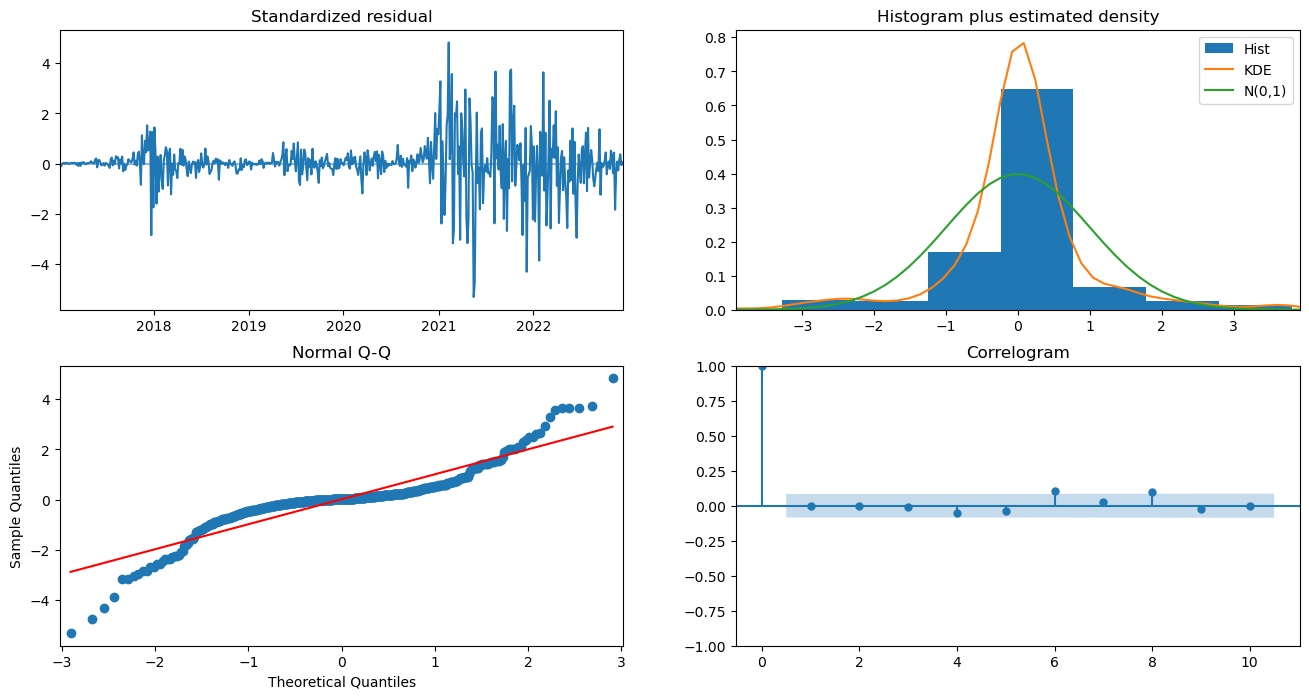

In [17]:
import matplotlib.pyplot as plt
model.plot_diagnostics(figsize=(16, 8))
plt.show()

In [18]:
y_train

x
2017-01-01      964.84
2017-01-05     1109.16
2017-01-09      910.49
2017-01-13      805.52
2017-01-17      830.56
                ...   
2022-11-27    16453.47
2022-12-01    17170.62
2022-12-05    17117.57
2022-12-09    17234.58
2022-12-13    17206.87
Name: y, Length: 544, dtype: float64

In [19]:
prediction = model.predict(n_periods = len(y_train))
prediction

2022-12-17    17203.541131
2022-12-21    17203.541131
2022-12-25    17203.541131
2022-12-29    17203.541131
2023-01-02    17203.541131
                  ...     
2028-11-11    17203.541131
2028-11-15    17203.541131
2028-11-19    17203.541131
2028-11-23    17203.541131
2028-11-27    17203.541131
Freq: 4D, Length: 544, dtype: float64

In [20]:
# 신뢰구간 -> return_conf_int
prediction, conf_int = model.predict(n_periods=2, return_conf_int=True) 
print(conf_int)
print(prediction)
# 결과적으로 신뢰구간의 평균값으로 예측한다.

[[13531.3330262  20875.74923639]
 [11781.87111969 22625.21114289]]
2022-12-17    17203.541131
2022-12-21    17203.541131
Freq: 4D, dtype: float64


In [21]:
prediction.tolist()[0]

17203.541131292302

In [22]:
# def predict_one_step():
#     prediction, conf_int = model.predict(n_periods=2, return_conf_int=True) 
#     return (prediction.tolist()[0], conf_int.tolist()[0])
def predict_one_step():
    prediction = model.predict(n_periods=1)
    return prediction.tolist()[0]

In [23]:
p_list = [] # Prediction
# conf_int_lower = [] # 신뢰구간 min
# cont_int_upper = [] # 신뢰구간 max

for data in y_test:
    p = predict_one_step()
    p_list.append(p)
    # conf_int_lower.append(c[0])
    # cont_int_upper.append(c[1])

    model.update(data)

In [24]:
y_predict_df = pd.DataFrame({"test" : y_test, "pred" : p_list})
y_predict_df

,test,pred
x,,
2022-12-17,16637.60,17203.541131
2022-12-21,16904.64,16588.820530
2022-12-25,16838.10,16931.825475
2022-12-29,16539.28,16830.033169
2023-01-02,16613.71,16514.245985
...,...,...
2024-05-24,67942.23,66234.722993
2024-05-28,69374.17,68073.747877
2024-06-01,67484.93,69475.407048


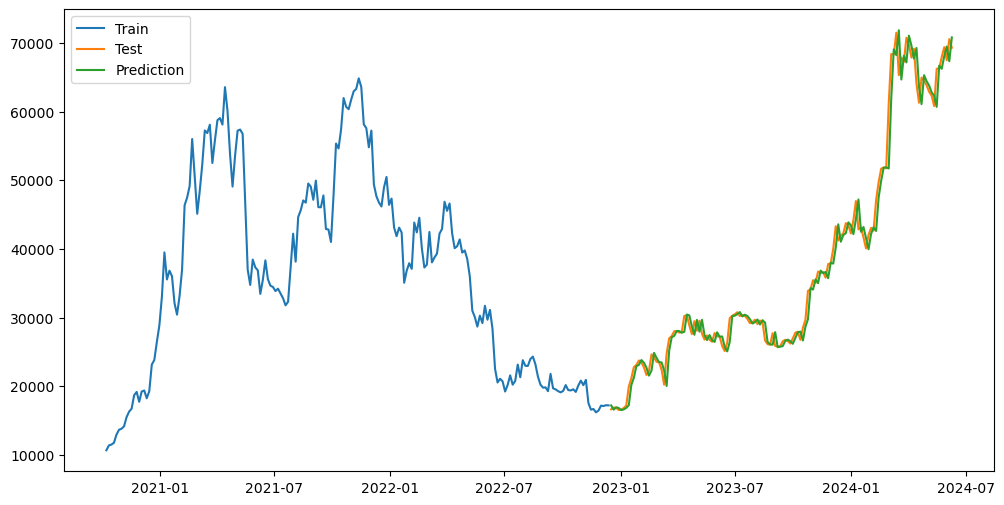

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

plt.plot(y_train.iloc[-200:], label='Train')
plt.plot(y_test.iloc[-200:], label='Test')
plt.plot(y_predict_df.pred, label='Prediction')
plt.legend()
plt.show()

In [26]:
import numpy as np

def MAPE(y_test, y_pred) :
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f'MAPE (%): {MAPE(y_test, p_list):.4f}')

MAPE (%): 3.5465


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 4D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 4D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 4D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


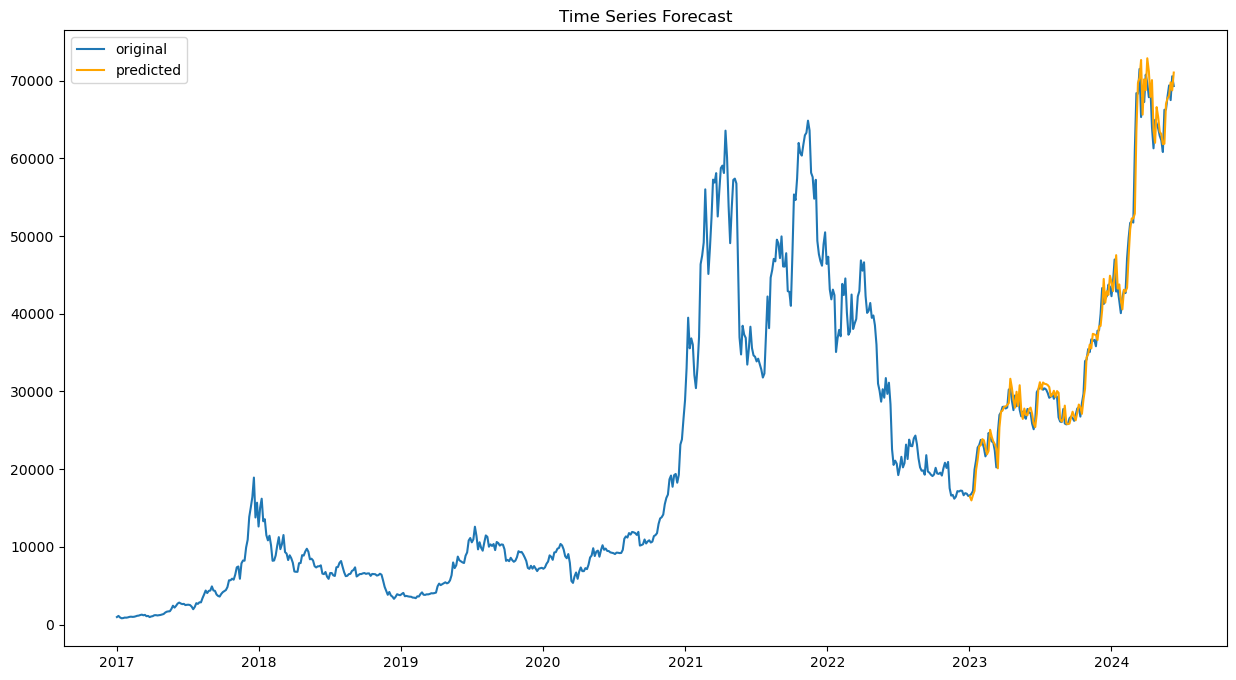

In [27]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(bitcoin_df, order=(1, 4, 21)) # 불안정 시계열 ARIMA , AR(자기회귀) -> 1,차분값 4, 이동평균값 21
model_fit = model.fit()

start_index = pd.to_datetime('2023-01-02')
end_index = pd.to_datetime('2024-06-09')
forecast = model_fit.predict(start=start_index, end=end_index) # 예측 실시

plt.figure(figsize=(15, 8))
plt.plot(bitcoin_df, label='original')
plt.plot(forecast, label='predicted', c='orange')
plt.title("Time Series Forecast")
plt.legend()
plt.show()